<a href="https://colab.research.google.com/github/elianaprosnitz/bio108tutorial/blob/main/Week_11_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The impact of wildfires on threatened species richness in California**

This analysis explores the question of how wildfires in California are impacting terrestrial species richness. With the concering increase in CA wildfires, this exploration will shed light on how these disasters are impacting biodiversity.


**Relevant paper**

Burkle, L. A., J. A. Myers, and R. T. Belote. 2015. Wildfire disturbance and productivity as drivers of plant species diversity across spatial scales. Ecosphere 6(10):202.

Access: [Wildfire disturbance and productivity as drivers of plant species diversity across spatial scales](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/ES15-00438.1)

**Major question(s):** How does wildfire severity influence spatial patterns of plant species diversity across a large-scale gradient of climate and productivity in the Northern Rockies Ecoregion (NRE) of the western United States?

**Hypotheses:**
1.   Communities that burned with high-severity fires would have low local species richness at low productivity but high local species richness at high productivity.
2.   Beta-diversity would be higher across landscapes with mixed-severity fires compared to landscapes with high-severity fires, but that the strength of this pattern would vary depending on productivity.

**Findings:**
Found that beta-diversity (community dispersion) of forbs was higher in mixed-severity compared to high-severity fire, regardless of productivity. Counter to predictions, local species richness of forbs was higher in burned landscapes compared to unburned landscapes at the low-productivity site, but lower in burned landscapes at the high-productivity site.

**My questions and objectives:**

1.   How do historic wildfires impact terrestrial species richness in California?
2.   Visually represent the terrestrial species richness compared to fire perimeters.
3.   Calculate the mean species richness within fire perimeters compared to outside fire perimeters.




**Data pre-processing**

Import necessary packages.

In [1]:
!pip install rasterio
!pip install rasterstats

In [2]:
# Import packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import fiona

Connect to Google Drive to access downloaded files.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
CA_wildfire_shp_path = '/content/drive/My Drive/California_Fire_Perimeters_(all)/California_Fire_Perimeters_(all).shp'
CA_wildfire = gpd.read_file(CA_wildfire_shp_path)

In [5]:
# URL to the ArcGIS GeoJSON
CA_SR_url = "https://data-cdfw.opendata.arcgis.com/api/download/v1/items/927417af9e694ad98c37a544da263db0/geojson?layers=0"

# Read the data into a GeoDataFrame
CA_SR = gpd.read_file(CA_SR_url)

**Visualization**

It is helpful to visualize our data as a heatmap of species richness, overlayed with the wildfire perimeter data.

<Axes: >

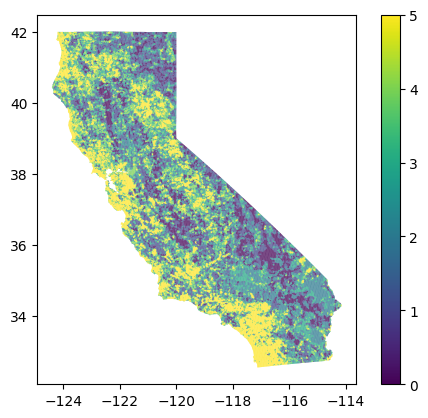

In [23]:
#Visualize the data
CA_SR.plot(column='RarRankSW', legend=True)

The wildfire data (CA_wildfire) is in EPSG:3857 (a projected CRS), and the species richness data (CA_SR) is in EPSG:4326 (a geographic CRS). Let's convert the wildfire data into EPSG:4326 to match our base layer.

In [11]:
CA_wildfire_geographic = CA_wildfire.to_crs(epsg=4326)

Now we can generate our combined plot.

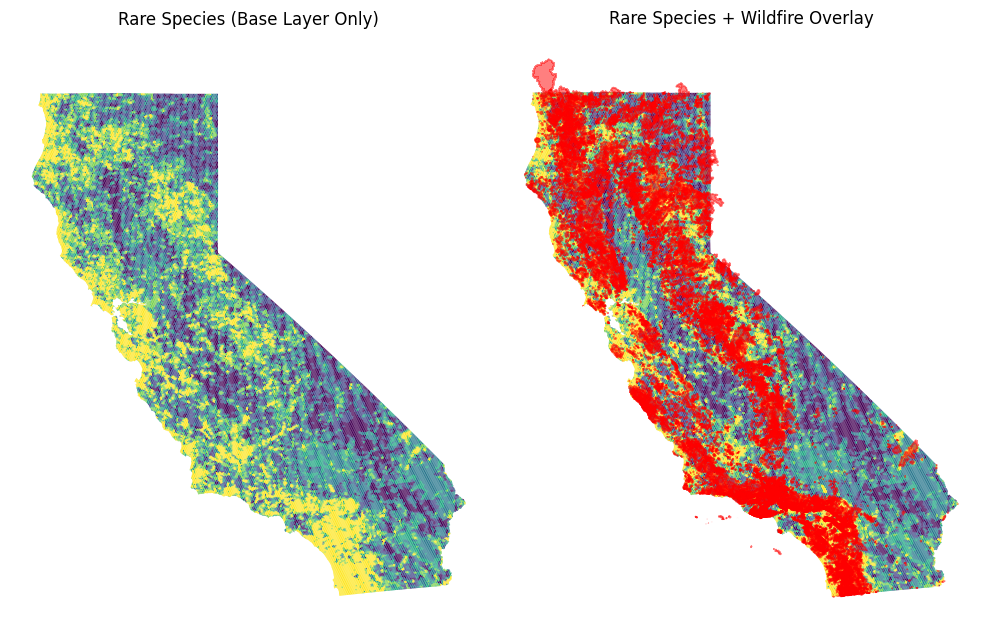

In [22]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

# Shared style settings
vmin = CA_SR['RarRankSW'].min()
vmax = CA_SR['RarRankSW'].max()

# Left: Base layer only
CA_SR.plot(
    column='RarRankSW',
    ax=ax1, vmin=vmin, vmax=vmax
)
ax1.set_title("Rare Species (Base Layer Only)")
ax1.set_axis_off()

# Right: Base layer and wildfire data
CA_SR.plot(
    column='RarRankSW',
    ax=ax2, vmin=vmin, vmax=vmax
)
CA_wildfire_geographic.plot(ax=ax2, facecolor='red', edgecolor='red', alpha = 0.5, linewidth=1)
ax2.set_title("Rare Species + Wildfire Overlay")
ax2.set_axis_off()

plt.tight_layout()
plt.show()

Merge the CA wildfire data into one geometry (multipolygon) so that we can look at the intersects and find the mean species richness rank inside and outside of fire perimeters.

In [8]:
CA_wildfire_merged = CA_wildfire_geographic.unary_union

<ipython-input-8-1537bbf3d372>:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  CA_wildfire_merged = CA_wildfire_geographic.unary_union


In [21]:
## inside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_merged, how='intersection')
## using the merged data set did not work, it could handle the "multipolygon" for some reason, so I just did it without

**Calculating means**

In order to compare species richness inside and outside of fire perimeters, I found the mean species richness in both overlapping areas and non-overlapping areas.

In [14]:
# Define the overlapping area using the gpd.overlap 'intersection' function.
inside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_geographic, how='intersection')

In [18]:
# Calculate the mean species richness inside fire perimeters and print the result.
inside_meanSR = inside_fire_perimeter['RarRankSW'].mean()
print(inside_meanSR)

3.349519158614161


In [19]:
# Define the NON-overlapping area using the gpd.overlap 'difference' function.
outside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_geographic, how='difference')

<ipython-input-19-f4047416b900>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  outside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_geographic, how='difference')


In [20]:
# Calculate the mean species richness outside fire perimeters and print the result.
outside_meanSR = outside_fire_perimeter['RarRankSW'].mean()
print(outside_meanSR)

2.586567721958251


**Results**


There is a positive correlation between wildfires and species richness. This is visible in the plots, but is more clearly reflected in the mean species richness results. The mean SR outside of the fire perimeter is lower (2.59) than inside the fire perimeter (3.35).

Correlation (famously) does not mean causation. It could be that there is higher species richness in regions more susceptible to fire danger. However, it could also reflect that wildfires promote habitat diversity and regeneration. These findings are in agreement with the paper referenced at the start of this markdown.